# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

Описание данных:  
    **Признаки**
    
* RowNumber — индекс строки в данных
* CustomerId — уникальный идентификатор клиента
* Surname — фамилия
* CreditScore — кредитный рейтинг
* Geography — страна проживания
* Gender — пол
* Age — возраст
* Tenure — количество недвижимости у клиента
* Balance — баланс на счёте
* NumOfProducts — количество продуктов банка, используемых клиентом
* HasCrCard — наличие кредитной карты
* IsActiveMember — активность клиента
* EstimatedSalary — предполагаемая зарплата

**Целевой признак**
* Exited — факт ухода клиента

In [1]:
# загрузим необходимые библиотеки:

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.dummy import DummyClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# 1. Подготовка данных

In [3]:
# загрузим датасет
raw_data = pd.read_csv('/datasets/Churn.csv')
raw_data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
raw_data['CustomerId'].value_counts().head()

15812607    1
15741078    1
15635776    1
15740223    1
15738174    1
Name: CustomerId, dtype: int64

In [5]:
# признаки RowNumber и Surname не принесут пользу при обучении модели,от них можно избавиться. Поле CustomerId сделаем индексным

raw_data.drop(['RowNumber', 'Surname'], axis=1, inplace=True)
raw_data.set_index('CustomerId', inplace=True)
raw_data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CustomerId,,,,,,,,,,,
15634602,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
15647311,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
15619304,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
15701354,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
15737888,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [6]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 15634602 to 15628319
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             9091 non-null float64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(3), int64(6), object(2)
memory usage: 937.5+ KB


In [7]:
# признак Tenure имеет nan значения. При этом вычитал на Stackowerflow, что fillna 
# нужно делать после разбивки на обучающую и тестовую выборки. Поэтому вернёмся к вопросу позже
raw_data['Tenure'].describe()

count    9091.000000
mean        4.997690
std         2.894723
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: Tenure, dtype: float64

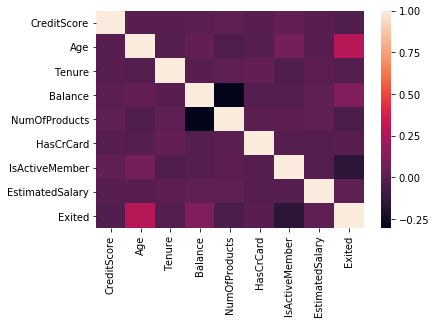

In [8]:
# оценим мультиколинеарность признаков:
corr = raw_data.corr()

# построим тепловую карту
sns.heatmap(corr, xticklabels=corr.columns,
            yticklabels=corr.columns);

In [9]:
corr

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.003965,-0.000062,0.006268,0.012238,-0.005458,0.025651,-0.001384,-0.027094
Age,-0.003965,1.000000,-0.013134,0.028308,-0.030680,-0.011721,0.085472,-0.007201,0.285323
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.006268,0.028308,-0.007911,1.000000,-0.304180,-0.014858,-0.010084,0.012797,0.118533
NumOfProducts,0.012238,-0.030680,0.011979,-0.304180,1.000000,0.003183,0.009612,0.014204,-0.047820
HasCrCard,-0.005458,-0.011721,0.027232,-0.014858,0.003183,1.000000,-0.011866,-0.009933,-0.007138
IsActiveMember,0.025651,0.085472,-0.032178,-0.010084,0.009612,-0.011866,1.000000,-0.011421,-0.156128
EstimatedSalary,-0.001384,-0.007201,0.010520,0.012797,0.014204,-0.009933,-0.011421,1.000000,0.012097
Exited,-0.027094,0.285323,-0.016761,0.118533,-0.047820,-0.007138,-0.156128,0.012097,1.000000


**Похоже существенная корреляция между признаками отсутствует, избавляться от мультиколинеарности не нужно**

In [10]:
# закодируем категориальные признаки методом OHE

ohe_data = pd.get_dummies(raw_data, drop_first=True)

In [11]:
#разделим набор данных на обучающую, валидационную и тестовую выборки

df_x, df_test = train_test_split(ohe_data, test_size=0.2, random_state=12345)
df_train, df_valid = train_test_split(df_x, test_size=0.25, random_state=12345)

features_train = df_train.drop(columns='Exited')
target_train = df_train['Exited']

features_valid = df_valid.drop(columns='Exited')
target_valid = df_valid['Exited']

features_test = df_test.drop(columns='Exited')
target_test = df_test['Exited']

In [12]:
print(features_train['Tenure'].isna().sum())
print(features_valid['Tenure'].isna().sum())
print(features_test['Tenure'].isna().sum())

570
173
166


In [13]:
# заполним отсутстствующие данные по параметру Tenure медианой
features_train.fillna(features_train['Tenure'].median(), inplace=True)
features_valid.fillna(features_valid['Tenure'].median(), inplace=True)
features_test.fillna(features_test['Tenure'].median(), inplace=True)

# 2. Исследование задачи

In [14]:
#посмотрим, как распределены классы в данных:
raw_data['Exited'].value_counts(normalize=True)

0    0.7963
1    0.2037
Name: Exited, dtype: float64

**в целевом признаке присутствует дисбаланс**

In [15]:
%%time
# начнём с дерева решений, меняя гиперпараметр max_depth в диапазоне от 1 до 10

best_depth, best_result  = 0, 0
for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        dtc_model = model
        best_result = result
        best_depth = depth

prediction = dtc_model.predict(features_valid)
prediction_proba = dtc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)
print("Метрика f1 наилучшей модели деревьев решений на валидационной выборке без балансирови:", best_result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))
print(f"Значение depth = {best_depth}")


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Метрика f1 наилучшей модели деревьев решений на валидационной выборке без балансирови: 0.5584
Значение метрики AUC-ROC лучшей модели: 0.8231
Значение depth = 7
CPU times: user 230 ms, sys: 3.07 ms, total: 234 ms
Wall time: 242 ms


In [16]:
%%time
# посмотрим на результаты модели логистической регрессии

lr_model = LogisticRegression(random_state=12345)
lr_model.fit(features_train, target_train)
prediction = lr_model.predict(features_valid)
prediction_proba = lr_model.predict_proba(features_valid)[:,1]
result = f1_score(target_valid, prediction)
auc_roc = roc_auc_score(target_valid, prediction_proba)

print("F1 модели модели логистической регрессии на валидационной выборке без балансировки:", result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

F1 модели модели логистической регрессии на валидационной выборке без балансировки: 0.1029
Значение метрики AUC-ROC лучшей модели: 0.6814
CPU times: user 73.4 ms, sys: 21.6 ms, total: 95 ms
Wall time: 95.6 ms


In [17]:
%%time
# закончим случайным лесом. Сначала подберем гиперпараметр max_depth в диапазоне от 1 до 20

best_depth, best_result  = 0, 0
for depth in range(1,21,1):
    model = RandomForestClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

print(f"Значение depth = {best_depth}, значение метрики f1 = {best_result.round(4)}")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Значение depth = 14, значение метрики f1 = 0.5543
CPU times: user 1.65 s, sys: 5.08 ms, total: 1.66 s
Wall time: 1.67 s


In [18]:
%%time
# продолжим подбором параметра n_estimator

best_depth, best_result  = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators,max_depth=14, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

prediction = rfc_model.predict(features_valid)
prediction_proba = rfc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)

print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Значение n_estimators = 90, значение метрики f1 = 0.5774
Значение метрики AUC-ROC лучшей модели: 0.838
CPU times: user 4.34 s, sys: 25.3 ms, total: 4.36 s
Wall time: 4.48 s


**По итогу первого применения моделей наилучший результат по метрике f1 у случайного леса, наихудший у модели логистической регрессии (0,10), при этом метрика auc_roc для логистической регрессии составила 0.68, что лучше чем значение 0.5 для "случайной модели"**

In [19]:
# стандартизируеем числовые признаки функцией StandardScaler и проверим, как это отразится на качестве предсказания

numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [20]:
%%time
# начнём с дерева решений, меняя гиперпараметр max_depth в диапазоне от 1 до 10

best_depth, best_result  = 0, 0
for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        dtc_model = model
        best_result = result
        best_depth = depth

prediction = dtc_model.predict(features_valid)
prediction_proba = dtc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)
print("Метрика f1 наилучшей модели деревьев решений на валидационной выборке без балансирови:", best_result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))
print(f"Значение depth = {best_depth}")

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Метрика f1 наилучшей модели деревьев решений на валидационной выборке без балансирови: 0.5584
Значение метрики AUC-ROC лучшей модели: 0.8231
Значение depth = 7
CPU times: user 229 ms, sys: 0 ns, total: 229 ms
Wall time: 234 ms


In [21]:
%%time
# посмотрим на результаты модели логистической регрессии

lr_model = LogisticRegression(random_state=12345)
lr_model.fit(features_train, target_train)
prediction = lr_model.predict(features_valid)
prediction_proba = lr_model.predict_proba(features_valid)[:,1]
result = f1_score(target_valid, prediction)
auc_roc = roc_auc_score(target_valid, prediction_proba)

print("F1 модели модели логистической регрессии на валидационной выборке без балансировки:", result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

F1 модели модели логистической регрессии на валидационной выборке без балансировки: 0.3013
Значение метрики AUC-ROC лучшей модели: 0.7703
CPU times: user 59.4 ms, sys: 39.5 ms, total: 98.9 ms
Wall time: 48 ms


In [22]:
%%time
# закончим моделью случайного леса

best_depth, best_result  = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators,max_depth=14, random_state=12345)
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

prediction = rfc_model.predict(features_valid)
prediction_proba = rfc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)

print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Значение n_estimators = 90, значение метрики f1 = 0.5805
Значение метрики AUC-ROC лучшей модели: 0.8379
CPU times: user 4.36 s, sys: 6.84 ms, total: 4.37 s
Wall time: 4.38 s


**стандартизация никак не отразилась на модели дерева решений, немного улучшила модель случайного леса и в 3 раза улучшила метрику f1 для модели логистической регрессии**

# 3. Борьба с дисбалансом

In [23]:
# для борьбы с дисбалансом можно попробовать 3 варианта: учёт баланса в параметриах модели, upsampling и downsampling

In [24]:
%%time
# начнём с дерева решений

best_depth, best_result  = 0, 0
for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        dtc_model = model
        best_result = result
        best_depth = depth

prediction = dtc_model.predict(features_valid)
prediction_proba = dtc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)
print("Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через аргумент class_weight:", best_result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))
print(f"Значение depth = {best_depth}")

Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через аргумент class_weight: 0.5587
Значение метрики AUC-ROC лучшей модели: 0.8091
Значение depth = 6
CPU times: user 242 ms, sys: 26 µs, total: 242 ms
Wall time: 247 ms


In [25]:
%%time
# посмотрим на результаты модели логистической регрессии

lr_model = LogisticRegression(random_state=12345, class_weight='balanced')
lr_model.fit(features_train, target_train)
prediction = lr_model.predict(features_valid)
prediction_proba = lr_model.predict_proba(features_valid)[:,1]
result = f1_score(target_valid, prediction)
auc_roc = roc_auc_score(target_valid, prediction_proba)

print("F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через аргумент class_weight:", result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через аргумент class_weight: 0.4751
Значение метрики AUC-ROC лучшей модели: 0.7726
CPU times: user 114 ms, sys: 33.7 ms, total: 148 ms
Wall time: 142 ms


In [26]:
%%time
# закончим моделью случайного леса

best_depth, best_result  = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators,max_depth=14, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

prediction = rfc_model.predict(features_valid)
prediction_proba = rfc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)

print('Показатели с учётом балансировки через аргумент class_weight:')
print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Показатели с учётом балансировки через аргумент class_weight:
Значение n_estimators = 90, значение метрики f1 = 0.5816
Значение метрики AUC-ROC лучшей модели: 0.8443
CPU times: user 4.29 s, sys: 2.84 ms, total: 4.3 s
Wall time: 4.41 s


**Все модели показали небольшое улучшение по метрике f1, наибольшее улучшение показала модель логистической регрессии, при этом  AUC-ROC для дерева решений снизилась в сравнении с показателем без балансировки. Возможно это связано с тем, что данные изначально были разбалансированы**

In [27]:
# следующий метод - увеличение выборки

In [28]:
#подготовим функцию для увеличения событий с целевым признаком:
    
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled



In [29]:
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

#оценим результат апсемплинга:
target_upsampled.value_counts(normalize=True)

1    0.504919
0    0.495081
Name: Exited, dtype: float64

In [30]:
%%time
# начнём с дерева решений

best_depth, best_result  = 0, 0
for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        dtc_model = model
        best_result = result
        best_depth = depth

prediction = dtc_model.predict(features_valid)
prediction_proba = dtc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)
print("Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через upsampling:", best_result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))
print(f"Значение depth = {best_depth}")

Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через upsampling: 0.5587
Значение метрики AUC-ROC лучшей модели: 0.8091
Значение depth = 6
CPU times: user 304 ms, sys: 4.11 ms, total: 308 ms
Wall time: 329 ms


In [31]:
%%time
# посмотрим на результаты модели логистической регрессии

lr_model = LogisticRegression(random_state=12345)
lr_model.fit(features_upsampled, target_upsampled)
prediction = lr_model.predict(features_valid)
prediction_proba = lr_model.predict_proba(features_valid)[:,1]
result = f1_score(target_valid, prediction)
auc_roc = roc_auc_score(target_valid, prediction_proba)

print("F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через upsampling:", result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через upsampling: 0.4767
Значение метрики AUC-ROC лучшей модели: 0.7726
CPU times: user 71.8 ms, sys: 40.7 ms, total: 113 ms
Wall time: 101 ms


In [32]:
%%time
# закончим моделью случайного леса

best_depth, best_result  = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators, max_depth=14, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

prediction = rfc_model.predict(features_valid)
prediction_proba = rfc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)


print('Показатели с учётом балансировки через upsampling:')
print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Показатели с учётом балансировки через upsampling:
Значение n_estimators = 90, значение метрики f1 = 0.589
Значение метрики AUC-ROC лучшей модели: 0.8457
CPU times: user 6.39 s, sys: 10.6 ms, total: 6.4 s
Wall time: 6.51 s


**Наблдается небольшое улучшение метрик всех моделей, наименее заметное относительно вредыдущей итерации**

In [33]:
# следующий метод - снижение выборки

In [34]:

def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [35]:
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.25)

#оценим результат даунсемплинга:
target_downsampled.value_counts(normalize=True)

1    0.504971
0    0.495029
Name: Exited, dtype: float64

In [36]:
%%time
# начнём с дерева решений

best_depth, best_result  = 0, 0
for depth in range(1,11,1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        dtc_model = model
        best_result = result
        best_depth = depth

prediction = dtc_model.predict(features_valid)
prediction_proba = dtc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)
print("Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через downsampling:", best_result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))
print(f"Значение depth = {best_depth}")

Метрика f1 наилучшей модели деревьев решений на валидационной выборке с учётом балансирови через downsampling: 0.5493
Значение метрики AUC-ROC лучшей модели: 0.8144
Значение depth = 7
CPU times: user 122 ms, sys: 34 µs, total: 122 ms
Wall time: 148 ms


In [37]:
%%time
# продолжим с моделью логистической регрессии

lr_model = LogisticRegression(random_state=12345)
lr_model.fit(features_downsampled, target_downsampled)
prediction = lr_model.predict(features_valid)
prediction_proba = lr_model.predict_proba(features_valid)[:,1]
result = f1_score(target_valid, prediction)
auc_roc = roc_auc_score(target_valid, prediction_proba)

print("F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через downsampling:", result.round(4))
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

F1 модели модели логистической регрессии на валидационной выборке с учётом балансировки через downsampling: 0.475
Значение метрики AUC-ROC лучшей модели: 0.7738
CPU times: user 42.1 ms, sys: 56.2 ms, total: 98.3 ms
Wall time: 85.6 ms


In [38]:
%%time
# закончим моделью случайного леса

best_depth, best_result  = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators, max_depth=14, random_state=12345)
    model.fit(features_downsampled, target_downsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_model = model
        best_result = result
        best_depth = depth

prediction = rfc_model.predict(features_valid)
prediction_proba = rfc_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)


print('Показатели с учётом балансировки через downsampling:')
print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Показатели с учётом балансировки через downsampling:
Значение n_estimators = 90, значение метрики f1 = 0.5589
Значение метрики AUC-ROC лучшей модели: 0.8432
CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.32 s


**после даунсэмплинга наблюдается снижение метрики f1 у всех моделей, при этом auc_roc немного выросла для модели дерева решений**

**с учётом хороших показателей модели случайного леса с апсэмплингом остановимся на ней, но попробуем добавить в параметры class_weight='balanced'**

In [39]:
%%time
# модель случайного леса с апсэмплингом и параметром баланса классов

best_depth, best_result = 0, 0
for estimators in range(10,100,10):
    model = RandomForestClassifier(n_estimators=estimators, max_depth=14, random_state=12345, class_weight='balanced')
    model.fit(features_upsampled, target_upsampled)
    prediction = model.predict(features_valid)
    result = f1_score(target_valid, prediction)
    if result > best_result:
        rfc_upsampled_model = model
        best_result = result
        best_depth = depth

prediction = rfc_upsampled_model.predict(features_valid)
prediction_proba = rfc_upsampled_model.predict_proba(features_valid)[:,1]
auc_roc = roc_auc_score(target_valid, prediction_proba)


print('Показатели с учётом балансировки через upsampling и class_weight:')
print(f"Значение n_estimators = {estimators}, значение метрики f1 = {best_result.round(4)}")
print('Значение метрики AUC-ROC лучшей модели:', auc_roc.round(4))

Показатели с учётом балансировки через upsampling и class_weight:
Значение n_estimators = 90, значение метрики f1 = 0.5905
Значение метрики AUC-ROC лучшей модели: 0.8449
CPU times: user 6.39 s, sys: 26.6 ms, total: 6.42 s
Wall time: 6.43 s


In [40]:
# проверим модель на адекватность
dummy_clf = DummyClassifier( random_state=12345,)
dummy_clf.fit(features_upsampled, target_upsampled)
dummy_prediction = dummy_clf.predict(features_valid)
result = f1_score(target_valid, dummy_prediction)

print(f"Значение метрики f1 случайной модели = {result.round(4)}")


Значение метрики f1 случайной модели = 0.2656


**нам удалось добиться требуемого уровня метрики f1 на валидационной выборке и модель продемонстрировала свою адекватность**

# 4. Тестирование модели

In [41]:
# дообучим модель валидационными данными:
features_upsampled, target_upsampled = upsample(pd.concat([features_valid, features_train]),
                                                pd.concat([target_valid, target_train ]), 4)
rfc_upsampled_model.fit(features_upsampled, target_upsampled)

# посчитаем метрики:
test_prediction = rfc_upsampled_model.predict(features_test)
test_result = f1_score(target_test, test_prediction)
auc_roc = roc_auc_score(target_test, test_prediction)

print('Показатели метрик на тестовой выборке:')
print('Значение метрики f1:', test_result.round(4))
print('Значение метрики auc_roc:', auc_roc.round(4))

Показатели метрик на тестовой выборке:
Значение метрики f1: 0.6106
Значение метрики auc_roc: 0.7494


**на тестовых данных значение метрики f1 значительно лучше чем на тренировочных, но показатель auc_roc также заметно снизился. По данным из интернета, когда нам важно прогнозирование положительного класса, лучше всего подходит метрика f1, для ситуаций где важно прогнозирование обоих классов лучше использовать auc_roc**

# Вывод:

1. Данные были загружены и проанализированы. Мультиколинеарность между признаками отсутствует. В признаке Tenure были пропуски, которые были заполнены медианными значениями по соответствующему набору.

2. В датасете имеется дисбаланс по целевому признаку. По итогу первого применения моделей, без устранения дисбаланса, наилучший результат по метрике f1 у случайного леса, наихудший у модели логистической регрессии (0,10), при этом метрика auc_roc для логистической регрессии составила 0.68, что лучше чем значение 0.5 для "случайной модели"

3. Для балансировки данных были использованы три подхода: учёт баланса в параметриах модели, upsampling и downsampling. Наилучший результат продемонстрировал метод upsampling с моделью случайного леса, при этом макимальный результат был достигнут за счёт учёта в модели параметра class_weight='balanced'

4. По итогу тестирования модели,значение метрики f1 значительно лучше чем на тренировочных данных, но показатель auc_roc заметно снизился. С учётом дисбаланса целевого признака, лучше ориентироватьсяя именно на метрику f1